This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


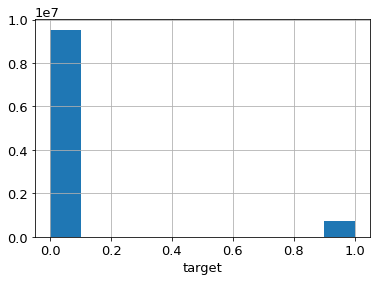

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8904038900654864


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 62.0 MB/s 
     |████████████████████████████████| 103 kB 52.3 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,id,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['id_pair'] = train[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['id_pair'] = test[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0,id_pair
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,1.000000,0,1.000000,33,33,33,0.000000,1.000000,1.000000,"(E_1104d3664585a4, E_be8ec27bf1b71b)"
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,0.451613,17,0.406746,7,24,7,0.708333,1.000000,0.291667,"(E_1514d74b987ae1, E_dfa69a18228406)"
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,0.300000,8,0.670034,5,11,9,0.727273,0.555556,0.454545,"(E_206f06060f193d, E_bb40eb6b8aa6c9)"
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,1.000000,0,1.000000,9,9,9,0.000000,1.000000,1.000000,"(E_20b7920b07557d, E_9acdcda349c154)"
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,1.000000,0,1.000000,20,20,20,0.000000,1.000000,1.000000,"(E_4a34a5012e88c3, E_bc8a2b3674875b)"


In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "id_pair"]]
test = test[features + ["id", "near_id", "id_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248613 entries, 0 to 10248612
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["id_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "id_pair"], train.loc[val_ind, "id_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,93.02%,6.98%
development set - fold 0,93.02%,6.98%
validation set - fold 0,93.02%,6.98%
development set - fold 1,93.02%,6.98%
validation set - fold 1,93.02%,6.98%
development set - fold 2,93.02%,6.98%
validation set - fold 2,93.02%,6.98%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.085649
[100]	valid_0's binary_logloss: 0.082535
[150]	valid_0's binary_logloss: 0.0810757
[200]	valid_0's binary_logloss: 0.0801694
[250]	valid_0's binary_logloss: 0.0794364
[300]	valid_0's binary_logloss: 0.0789034
[350]	valid_0's binary_logloss: 0.0784881
[400]	valid_0's binary_logloss: 0.0781156
[450]	valid_0's binary_logloss: 0.0778277
[500]	valid_0's binary_logloss: 0.0775607
[550]	valid_0's binary_logloss: 0.0773104
[600]	valid_0's binary_logloss: 0.0770532
[650]	valid_0's binary_logloss: 0.0768532
[700]	valid_0's binary_logloss: 0.0766459
[750]	valid_0's binary_logloss: 0.0764639
[800]	valid_0's binary_logloss: 0.0763531
[850]	valid_0's binary_logloss: 0.0761929
[900]	valid_0's binary_logloss: 0.0760923
[950]	valid_0's binary_logloss: 0.0759803
[1000]	valid_0's binary_logloss: 0.0758611
[1050]	valid_0's binary_logloss: 0.0757976
[1100]	valid_0's binary_logloss: 0.0757233
[1150]	valid_0's binary_logloss: 0.0756494
[1200]	valid_0's bin

In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 210 kB 65.0 MB/s 
     |████████████████████████████████| 78 kB 5.0 MB/s 
     |████████████████████████████████| 146 kB 67.6 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 112 kB 43.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=34bcd0b86d91b37f142f2f8df5c17917bbd502a62588783ea20191b32f1ff330
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 04:25:23,916] A new study created in memory with name: no-name-2b5f6a97-1da1-4de6-b228-03786fe6ab1d
[I 2022-05-14 04:25:56,724] Trial 0 finished with value: 0.786932070738336 and parameters: {'threshold': 0.15472844296738308}. Best is trial 0 with value: 0.786932070738336.


CV: 0.786932, precision: 0.902400, recall: 0.869889


[I 2022-05-14 04:26:21,880] Trial 1 finished with value: 0.8061014476625532 and parameters: {'threshold': 0.2677885255537966}. Best is trial 1 with value: 0.8061014476625532.


CV: 0.806101, precision: 0.935993, recall: 0.860639


[I 2022-05-14 04:26:44,175] Trial 2 finished with value: 0.8146188130947746 and parameters: {'threshold': 0.467510852787821}. Best is trial 2 with value: 0.8146188130947746.


CV: 0.814619, precision: 0.965238, recall: 0.844133


[I 2022-05-14 04:27:02,651] Trial 3 finished with value: 0.8021358287906697 and parameters: {'threshold': 0.74020096538319}. Best is trial 2 with value: 0.8146188130947746.


CV: 0.802136, precision: 0.986621, recall: 0.813320


[I 2022-05-14 04:27:17,803] Trial 4 finished with value: 0.7480451933184276 and parameters: {'threshold': 0.952584545133099}. Best is trial 2 with value: 0.8146188130947746.


CV: 0.748045, precision: 0.997685, recall: 0.749949


[I 2022-05-14 04:27:36,083] Trial 5 finished with value: 0.7866208841258525 and parameters: {'threshold': 0.8481223824393581}. Best is trial 2 with value: 0.8146188130947746.


CV: 0.786621, precision: 0.992411, recall: 0.792926


[I 2022-05-14 04:27:58,122] Trial 6 finished with value: 0.814644476916902 and parameters: {'threshold': 0.4644252542738717}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814644, precision: 0.964935, recall: 0.844413


[I 2022-05-14 04:28:23,316] Trial 7 finished with value: 0.7961963073910787 and parameters: {'threshold': 0.19599813420723455}. Best is trial 6 with value: 0.814644476916902.


CV: 0.796196, precision: 0.917511, recall: 0.866422


[I 2022-05-14 04:28:47,677] Trial 8 finished with value: 0.8115804189247576 and parameters: {'threshold': 0.34104007121707025}. Best is trial 6 with value: 0.814644476916902.


CV: 0.811580, precision: 0.949182, recall: 0.854873


[I 2022-05-14 04:29:19,441] Trial 9 finished with value: 0.7537083326660003 and parameters: {'threshold': 0.07929878513544208}. Best is trial 6 with value: 0.814644476916902.


CV: 0.753708, precision: 0.853598, recall: 0.877064


[I 2022-05-14 04:29:40,663] Trial 10 finished with value: 0.8095807577468944 and parameters: {'threshold': 0.6442461537898976}. Best is trial 6 with value: 0.814644476916902.


CV: 0.809581, precision: 0.980419, recall: 0.826056


[I 2022-05-14 04:30:02,906] Trial 11 finished with value: 0.8145756415775173 and parameters: {'threshold': 0.4844276601401538}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814576, precision: 0.966989, recall: 0.842586


[I 2022-05-14 04:30:24,962] Trial 12 finished with value: 0.8145526647968767 and parameters: {'threshold': 0.4884267492851879}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814553, precision: 0.967387, recall: 0.842217


[I 2022-05-14 04:30:44,937] Trial 13 finished with value: 0.8108738184460323 and parameters: {'threshold': 0.6195762250928232}. Best is trial 6 with value: 0.814644476916902.


CV: 0.810874, precision: 0.978579, recall: 0.828912


[I 2022-05-14 04:31:09,190] Trial 14 finished with value: 0.8128736021960072 and parameters: {'threshold': 0.3697543723893497}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812874, precision: 0.953401, recall: 0.852557


[I 2022-05-14 04:31:30,200] Trial 15 finished with value: 0.8117693279897699 and parameters: {'threshold': 0.6001600646921972}. Best is trial 6 with value: 0.814644476916902.


CV: 0.811769, precision: 0.977106, recall: 0.831063


[I 2022-05-14 04:31:53,006] Trial 16 finished with value: 0.8134097011969043 and parameters: {'threshold': 0.3841029431459271}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813410, precision: 0.955381, recall: 0.851395


[I 2022-05-14 04:32:14,647] Trial 17 finished with value: 0.8143814600824422 and parameters: {'threshold': 0.5068239515506212}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814381, precision: 0.969199, recall: 0.840503


[I 2022-05-14 04:32:33,706] Trial 18 finished with value: 0.799498393934752 and parameters: {'threshold': 0.7644839115764952}. Best is trial 6 with value: 0.814644476916902.


CV: 0.799498, precision: 0.987992, recall: 0.809521


[I 2022-05-14 04:32:56,080] Trial 19 finished with value: 0.8143556244917038 and parameters: {'threshold': 0.4290140428962496}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814356, precision: 0.960966, recall: 0.847527


[I 2022-05-14 04:33:38,484] Trial 20 finished with value: 0.5347950318995264 and parameters: {'threshold': 0.006059512617305307}. Best is trial 6 with value: 0.814644476916902.


CV: 0.534795, precision: 0.579725, recall: 0.887988


[I 2022-05-14 04:33:59,814] Trial 21 finished with value: 0.814139157225239 and parameters: {'threshold': 0.5212139257117695}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814139, precision: 0.970513, recall: 0.839126


[I 2022-05-14 04:34:25,002] Trial 22 finished with value: 0.8074696095623523 and parameters: {'threshold': 0.2821480327925151}. Best is trial 6 with value: 0.814644476916902.


CV: 0.807470, precision: 0.938922, recall: 0.859528


[I 2022-05-14 04:34:45,143] Trial 23 finished with value: 0.8130238968303839 and parameters: {'threshold': 0.56749889707943}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813024, precision: 0.974556, recall: 0.834524


[I 2022-05-14 04:35:06,008] Trial 24 finished with value: 0.8060643840195034 and parameters: {'threshold': 0.6975045389891465}. Best is trial 6 with value: 0.814644476916902.


CV: 0.806064, precision: 0.984054, recall: 0.819447


[I 2022-05-14 04:35:28,403] Trial 25 finished with value: 0.8144468898416559 and parameters: {'threshold': 0.4392193199143467}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814447, precision: 0.962127, recall: 0.846625


[I 2022-05-14 04:35:52,415] Trial 26 finished with value: 0.8104001226185169 and parameters: {'threshold': 0.3217194406090004}. Best is trial 6 with value: 0.814644476916902.


CV: 0.810400, precision: 0.946013, recall: 0.856413


[I 2022-05-14 04:36:14,880] Trial 27 finished with value: 0.8143877197185193 and parameters: {'threshold': 0.4332685455090143}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814388, precision: 0.961451, recall: 0.847146


[I 2022-05-14 04:36:39,919] Trial 28 finished with value: 0.7990112619903409 and parameters: {'threshold': 0.21215732801069032}. Best is trial 6 with value: 0.814644476916902.


CV: 0.799011, precision: 0.922390, recall: 0.865091


[I 2022-05-14 04:37:01,413] Trial 29 finished with value: 0.8134934549375359 and parameters: {'threshold': 0.5517873673911432}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813493, precision: 0.973245, recall: 0.836119


[I 2022-05-14 04:37:21,772] Trial 30 finished with value: 0.8067490747699281 and parameters: {'threshold': 0.68848442946628}. Best is trial 6 with value: 0.814644476916902.


CV: 0.806749, precision: 0.983470, recall: 0.820624


[I 2022-05-14 04:37:44,672] Trial 31 finished with value: 0.8146191946955902 and parameters: {'threshold': 0.46794618535660504}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814619, precision: 0.965280, recall: 0.844097


[I 2022-05-14 04:38:06,856] Trial 32 finished with value: 0.8146118091297155 and parameters: {'threshold': 0.4710652935459202}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814612, precision: 0.965615, recall: 0.843807


[I 2022-05-14 04:38:29,650] Trial 33 finished with value: 0.8137557269759951 and parameters: {'threshold': 0.3988203333428204}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813756, precision: 0.957279, recall: 0.850103


[I 2022-05-14 04:38:53,594] Trial 34 finished with value: 0.8080056340726982 and parameters: {'threshold': 0.2886053764894126}. Best is trial 6 with value: 0.814644476916902.


CV: 0.808006, precision: 0.940152, recall: 0.859024


[I 2022-05-14 04:39:15,522] Trial 35 finished with value: 0.8146041318958764 and parameters: {'threshold': 0.4770563386152828}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814604, precision: 0.966240, recall: 0.843256


[I 2022-05-14 04:39:34,491] Trial 36 finished with value: 0.7922068226049113 and parameters: {'threshold': 0.8175259384062459}. Best is trial 6 with value: 0.814644476916902.


CV: 0.792207, precision: 0.990831, recall: 0.799824


[I 2022-05-14 04:39:56,036] Trial 37 finished with value: 0.8133351702391258 and parameters: {'threshold': 0.5567675641758624}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813335, precision: 0.973657, recall: 0.835608


[I 2022-05-14 04:40:21,733] Trial 38 finished with value: 0.8020406526324786 and parameters: {'threshold': 0.23293745387915943}. Best is trial 6 with value: 0.814644476916902.


CV: 0.802041, precision: 0.927931, recall: 0.863428


[I 2022-05-14 04:40:35,955] Trial 39 finished with value: 0.7469562410575536 and parameters: {'threshold': 0.9541588299326109}. Best is trial 6 with value: 0.814644476916902.


CV: 0.746956, precision: 0.997776, recall: 0.748783


[I 2022-05-14 04:41:03,630] Trial 40 finished with value: 0.7826954539585987 and parameters: {'threshold': 0.1403788195388158}. Best is trial 6 with value: 0.814644476916902.


CV: 0.782695, precision: 0.895862, recall: 0.871152


[I 2022-05-14 04:41:27,977] Trial 41 finished with value: 0.8145145729209214 and parameters: {'threshold': 0.44594883118384276}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814515, precision: 0.962884, recall: 0.846042


[I 2022-05-14 04:41:51,276] Trial 42 finished with value: 0.8117489166864857 and parameters: {'threshold': 0.3443034311473512}. Best is trial 6 with value: 0.814644476916902.


CV: 0.811749, precision: 0.949693, recall: 0.854608


[I 2022-05-14 04:42:13,134] Trial 43 finished with value: 0.8144644748520496 and parameters: {'threshold': 0.4969611927469649}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814464, precision: 0.968230, recall: 0.841409


[I 2022-05-14 04:42:33,416] Trial 44 finished with value: 0.809192813619729 and parameters: {'threshold': 0.6516111986996052}. Best is trial 6 with value: 0.814644476916902.


CV: 0.809193, precision: 0.980964, recall: 0.825202


[I 2022-05-14 04:42:55,578] Trial 45 finished with value: 0.8146058108188324 and parameters: {'threshold': 0.46945037685349633}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814606, precision: 0.965438, recall: 0.843949


[I 2022-05-14 04:43:16,191] Trial 46 finished with value: 0.8121338188362641 and parameters: {'threshold': 0.591538614613008}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812134, precision: 0.976445, recall: 0.832001


[I 2022-05-14 04:43:39,801] Trial 47 finished with value: 0.8135150151914543 and parameters: {'threshold': 0.3889872698345862}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813515, precision: 0.956008, recall: 0.850960


[I 2022-05-14 04:44:00,905] Trial 48 finished with value: 0.8139551311494647 and parameters: {'threshold': 0.5324620011871926}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813955, precision: 0.971539, recall: 0.838058


[I 2022-05-14 04:44:22,674] Trial 49 finished with value: 0.8146394099060449 and parameters: {'threshold': 0.4659653505847557}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814639, precision: 0.965098, recall: 0.844270


[I 2022-05-14 04:44:45,615] Trial 50 finished with value: 0.811756226959136 and parameters: {'threshold': 0.3443992307711265}. Best is trial 6 with value: 0.814644476916902.


CV: 0.811756, precision: 0.949711, recall: 0.854600


[I 2022-05-14 04:45:07,780] Trial 51 finished with value: 0.8146400212067427 and parameters: {'threshold': 0.4637291056558814}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814640, precision: 0.964862, recall: 0.844473


[I 2022-05-14 04:45:31,030] Trial 52 finished with value: 0.8143328050919163 and parameters: {'threshold': 0.4273120254284077}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814333, precision: 0.960761, recall: 0.847681


[I 2022-05-14 04:45:52,415] Trial 53 finished with value: 0.8143136349479234 and parameters: {'threshold': 0.5104078096775967}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814314, precision: 0.969532, recall: 0.840150


[I 2022-05-14 04:46:15,216] Trial 54 finished with value: 0.8138267317034467 and parameters: {'threshold': 0.40202614893832145}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813827, precision: 0.957670, recall: 0.849835


[I 2022-05-14 04:46:35,826] Trial 55 finished with value: 0.8105330635847742 and parameters: {'threshold': 0.6263499095499495}. Best is trial 6 with value: 0.814644476916902.


CV: 0.810533, precision: 0.979100, recall: 0.828129


[I 2022-05-14 04:46:59,623] Trial 56 finished with value: 0.809510793472737 and parameters: {'threshold': 0.30870057441511145}. Best is trial 6 with value: 0.814644476916902.


CV: 0.809511, precision: 0.943805, recall: 0.857429


[I 2022-05-14 04:47:20,519] Trial 57 finished with value: 0.8125312670308037 and parameters: {'threshold': 0.581684020709172}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812531, precision: 0.975692, recall: 0.833049


[I 2022-05-14 04:47:42,247] Trial 58 finished with value: 0.8146082125943536 and parameters: {'threshold': 0.4730119730855001}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814608, precision: 0.965819, recall: 0.843624


[I 2022-05-14 04:48:05,145] Trial 59 finished with value: 0.8127685056090933 and parameters: {'threshold': 0.36748428520086146}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812769, precision: 0.953081, recall: 0.852733


[I 2022-05-14 04:48:26,426] Trial 60 finished with value: 0.8138252672026207 and parameters: {'threshold': 0.5384939721769909}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813825, precision: 0.972075, recall: 0.837463


[I 2022-05-14 04:48:48,272] Trial 61 finished with value: 0.814587885264662 and parameters: {'threshold': 0.4536308648638534}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814588, precision: 0.963749, recall: 0.845375


[I 2022-05-14 04:49:09,866] Trial 62 finished with value: 0.814502750523698 and parameters: {'threshold': 0.4945113836262053}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814503, precision: 0.967993, recall: 0.841650


[I 2022-05-14 04:49:36,546] Trial 63 finished with value: 0.8141648747262153 and parameters: {'threshold': 0.41481419420003296}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814165, precision: 0.959280, recall: 0.848790


[I 2022-05-14 04:49:58,660] Trial 64 finished with value: 0.8146124657487512 and parameters: {'threshold': 0.47081354894418176}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814612, precision: 0.965589, recall: 0.843829


[I 2022-05-14 04:50:20,190] Trial 65 finished with value: 0.8139604143517338 and parameters: {'threshold': 0.5322476118439563}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813960, precision: 0.971523, recall: 0.838076


[I 2022-05-14 04:50:43,165] Trial 66 finished with value: 0.8129652368780569 and parameters: {'threshold': 0.37210250812090223}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812965, precision: 0.953722, recall: 0.852376


[I 2022-05-14 04:51:05,340] Trial 67 finished with value: 0.814608666423718 and parameters: {'threshold': 0.45608617776338006}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814609, precision: 0.964026, recall: 0.845158


[I 2022-05-14 04:51:26,110] Trial 68 finished with value: 0.8118591700315069 and parameters: {'threshold': 0.59835994039518}. Best is trial 6 with value: 0.814644476916902.


CV: 0.811859, precision: 0.976976, recall: 0.831266


[I 2022-05-14 04:51:46,281] Trial 69 finished with value: 0.8084439253712308 and parameters: {'threshold': 0.6635778294254139}. Best is trial 6 with value: 0.814644476916902.


CV: 0.808444, precision: 0.981779, recall: 0.823761


[I 2022-05-14 04:52:02,666] Trial 70 finished with value: 0.7754405828218732 and parameters: {'threshold': 0.8930161722427359}. Best is trial 6 with value: 0.814644476916902.


CV: 0.775441, precision: 0.994662, recall: 0.779862


[I 2022-05-14 04:52:24,443] Trial 71 finished with value: 0.8145981382651358 and parameters: {'threshold': 0.45485559717845936}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814598, precision: 0.963887, recall: 0.845267


[I 2022-05-14 04:52:46,620] Trial 72 finished with value: 0.8143084149784374 and parameters: {'threshold': 0.5108694464411653}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814308, precision: 0.969570, recall: 0.840110


[I 2022-05-14 04:53:07,606] Trial 73 finished with value: 0.8133358480439341 and parameters: {'threshold': 0.5566319750464941}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813336, precision: 0.973643, recall: 0.835620


[I 2022-05-14 04:53:29,886] Trial 74 finished with value: 0.8143931847763647 and parameters: {'threshold': 0.43394496752579936}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814393, precision: 0.961528, recall: 0.847086


[I 2022-05-14 04:53:51,692] Trial 75 finished with value: 0.8146096903909176 and parameters: {'threshold': 0.472197668882443}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814610, precision: 0.965730, recall: 0.843703


[I 2022-05-14 04:54:13,476] Trial 76 finished with value: 0.8146054785838999 and parameters: {'threshold': 0.4767896698895779}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814605, precision: 0.966214, recall: 0.843278


[I 2022-05-14 04:54:35,767] Trial 77 finished with value: 0.8140769328318936 and parameters: {'threshold': 0.41138141151610946}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814077, precision: 0.958851, recall: 0.849068


[I 2022-05-14 04:54:58,682] Trial 78 finished with value: 0.812595007781572 and parameters: {'threshold': 0.3634841669463954}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812595, precision: 0.952504, recall: 0.853052


[I 2022-05-14 04:55:19,955] Trial 79 finished with value: 0.814167046487607 and parameters: {'threshold': 0.518382560892197}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814167, precision: 0.970247, recall: 0.839387


[I 2022-05-14 04:55:43,947] Trial 80 finished with value: 0.8056612432515065 and parameters: {'threshold': 0.26340183600595823}. Best is trial 6 with value: 0.814644476916902.


CV: 0.805661, precision: 0.935057, recall: 0.860990


[I 2022-05-14 04:56:05,767] Trial 81 finished with value: 0.814547332793107 and parameters: {'threshold': 0.4509217110695207}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814547, precision: 0.963447, recall: 0.845596


[I 2022-05-14 04:56:28,111] Trial 82 finished with value: 0.8145440919113622 and parameters: {'threshold': 0.49218002003790023}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814544, precision: 0.967769, recall: 0.841883


[I 2022-05-14 04:56:50,761] Trial 83 finished with value: 0.8139486542818052 and parameters: {'threshold': 0.40674982085462413}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813949, precision: 0.958259, recall: 0.849442


[I 2022-05-14 04:57:12,029] Trial 84 finished with value: 0.8129837667868707 and parameters: {'threshold': 0.5689012844708956}. Best is trial 6 with value: 0.814644476916902.


CV: 0.812984, precision: 0.974679, recall: 0.834374


[I 2022-05-14 04:57:33,979] Trial 85 finished with value: 0.8146105849065535 and parameters: {'threshold': 0.45810820070832947}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814611, precision: 0.964252, recall: 0.844967


[I 2022-05-14 04:57:56,511] Trial 86 finished with value: 0.8134821815036085 and parameters: {'threshold': 0.387595504238542}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813482, precision: 0.955833, recall: 0.851080


[I 2022-05-14 04:58:18,010] Trial 87 finished with value: 0.8145702073484739 and parameters: {'threshold': 0.48595716675471456}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814570, precision: 0.967142, recall: 0.842449


[I 2022-05-14 04:58:41,502] Trial 88 finished with value: 0.8099460243078629 and parameters: {'threshold': 0.3148302537306008}. Best is trial 6 with value: 0.814644476916902.


CV: 0.809946, precision: 0.944870, recall: 0.856945


[I 2022-05-14 04:59:04,757] Trial 89 finished with value: 0.8143329143318073 and parameters: {'threshold': 0.4269488141022719}. Best is trial 6 with value: 0.814644476916902.


CV: 0.814333, precision: 0.960723, recall: 0.847715


[I 2022-05-14 04:59:25,517] Trial 90 finished with value: 0.8112333984689633 and parameters: {'threshold': 0.6123278758538093}. Best is trial 6 with value: 0.814644476916902.


CV: 0.811233, precision: 0.978047, recall: 0.829733


[I 2022-05-14 04:59:46,637] Trial 91 finished with value: 0.8138715884409394 and parameters: {'threshold': 0.5366361195209893}. Best is trial 6 with value: 0.814644476916902.


CV: 0.813872, precision: 0.971924, recall: 0.837644


[I 2022-05-14 05:00:08,838] Trial 92 finished with value: 0.8146497431838916 and parameters: {'threshold': 0.4649589470811246}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.814650, precision: 0.964994, recall: 0.844369


[I 2022-05-14 05:00:30,802] Trial 93 finished with value: 0.814638184847809 and parameters: {'threshold': 0.4660799054580619}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.814638, precision: 0.965107, recall: 0.844262


[I 2022-05-14 05:00:52,352] Trial 94 finished with value: 0.8143524226236591 and parameters: {'threshold': 0.5085185343322556}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.814352, precision: 0.969356, recall: 0.840338


[I 2022-05-14 05:01:14,717] Trial 95 finished with value: 0.8144283868988201 and parameters: {'threshold': 0.4364844976260969}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.814428, precision: 0.961824, recall: 0.846863


[I 2022-05-14 05:01:37,868] Trial 96 finished with value: 0.8119176203730686 and parameters: {'threshold': 0.3472565384747263}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.811918, precision: 0.950157, recall: 0.854380


[I 2022-05-14 05:01:59,407] Trial 97 finished with value: 0.8146135438058846 and parameters: {'threshold': 0.4612619238632203}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.814614, precision: 0.964582, recall: 0.844685


[I 2022-05-14 05:02:20,697] Trial 98 finished with value: 0.8135231526258514 and parameters: {'threshold': 0.5499830257147053}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.813523, precision: 0.973084, recall: 0.836293


[I 2022-05-14 05:02:43,466] Trial 99 finished with value: 0.8142044659239083 and parameters: {'threshold': 0.4178500003296396}. Best is trial 92 with value: 0.8146497431838916.


CV: 0.814204, precision: 0.959648, recall: 0.848516


In [ ]:
threshold = study.best_params['threshold']
threshold

0.4649589470811246

In [ ]:
study.best_value

0.8146497431838916

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.814650, precision: 0.964994, recall: 0.844369


# Check Feature Importances

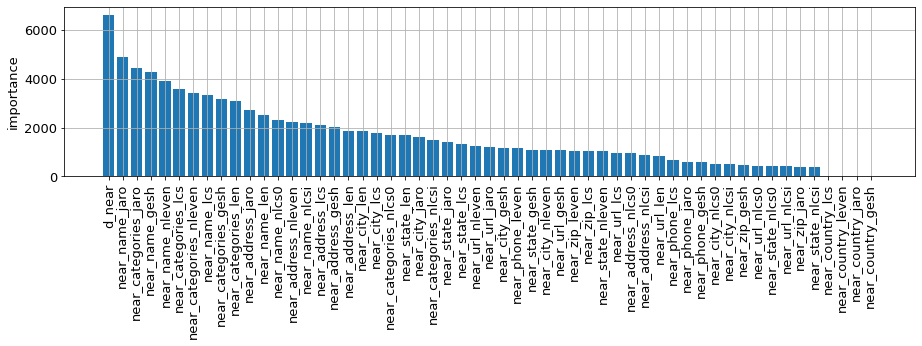

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 05:03:06,413] A new study created in memory with name: no-name-24d4be2e-72b3-497c-b180-c023944bfed4


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:04:27,599] Trial 0 finished with value: 0.81932363683842 and parameters: {'threshold': 0.4854921719143823}. Best is trial 0 with value: 0.81932363683842.


CV: 0.819324, precision: 0.960355, recall: 0.853169


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:05:43,152] Trial 1 finished with value: 0.8194769971462142 and parameters: {'threshold': 0.5152430916698428}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819477, precision: 0.963691, recall: 0.850448


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:06:37,891] Trial 2 finished with value: 0.7512417230642329 and parameters: {'threshold': 0.9606311272570075}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.751242, precision: 0.997530, recall: 0.753262


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812700, precision: 0.981624, recall: 0.828181


[I 2022-05-14 05:07:45,926] Trial 3 finished with value: 0.8126997984111773 and parameters: {'threshold': 0.7138806514892854}. Best is trial 1 with value: 0.8194769971462142.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:08:56,644] Trial 4 finished with value: 0.8106535864952764 and parameters: {'threshold': 0.737583142441635}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.810654, precision: 0.983271, recall: 0.824695


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:09:52,677] Trial 5 finished with value: 0.7496797042677745 and parameters: {'threshold': 0.9624602532970308}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.749680, precision: 0.997662, recall: 0.751592


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:11:09,380] Trial 6 finished with value: 0.8185627556700933 and parameters: {'threshold': 0.4488350148108693}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.818563, precision: 0.955789, recall: 0.856359


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:12:12,152] Trial 7 finished with value: 0.7807236560876284 and parameters: {'threshold': 0.9067944254647068}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.780724, precision: 0.994136, recall: 0.785582


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.805691, precision: 0.924314, recall: 0.870667


[I 2022-05-14 05:13:38,696] Trial 8 finished with value: 0.8056909041124408 and parameters: {'threshold': 0.2680252244564105}. Best is trial 1 with value: 0.8194769971462142.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.807391, precision: 0.927468, recall: 0.869674


[I 2022-05-14 05:15:03,644] Trial 9 finished with value: 0.8073914269088597 and parameters: {'threshold': 0.2812555922020522}. Best is trial 1 with value: 0.8194769971462142.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:16:49,604] Trial 10 finished with value: 0.681229286546497 and parameters: {'threshold': 0.03459043375523657}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.681229, precision: 0.751474, recall: 0.891723


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:18:05,130] Trial 11 finished with value: 0.8194004870846568 and parameters: {'threshold': 0.5403725972736213}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819400, precision: 0.966389, recall: 0.848028


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:19:18,585] Trial 12 finished with value: 0.8192691494243458 and parameters: {'threshold': 0.553317016304175}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819269, precision: 0.967711, recall: 0.846740


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:20:28,649] Trial 13 finished with value: 0.8151946941314311 and parameters: {'threshold': 0.6765918857637562}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.815195, precision: 0.978761, recall: 0.833130


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:21:52,336] Trial 14 finished with value: 0.8163092900083967 and parameters: {'threshold': 0.3894499077911984}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.816309, precision: 0.947448, recall: 0.861329


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:23:06,227] Trial 15 finished with value: 0.8188933311884793 and parameters: {'threshold': 0.576249672928202}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.818893, precision: 0.969973, recall: 0.844395


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:24:27,591] Trial 16 finished with value: 0.8106969438437759 and parameters: {'threshold': 0.3131694223197804}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.810697, precision: 0.934161, recall: 0.867235


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:26:07,400] Trial 17 finished with value: 0.7596092225566843 and parameters: {'threshold': 0.10373815855568186}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.759609, precision: 0.854124, recall: 0.884164


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:27:31,840] Trial 18 finished with value: 0.8166681675234064 and parameters: {'threshold': 0.6461817558031202}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.816668, precision: 0.976254, recall: 0.836761


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:28:48,937] Trial 19 finished with value: 0.8074406175447226 and parameters: {'threshold': 0.7698519509765056}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.807441, precision: 0.985485, recall: 0.819570


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.793021, precision: 0.902871, recall: 0.876362


[I 2022-05-14 05:30:15,743] Trial 20 finished with value: 0.7930207402808365 and parameters: {'threshold': 0.19545851370720874}. Best is trial 1 with value: 0.8194769971462142.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:31:32,241] Trial 21 finished with value: 0.8194242239497559 and parameters: {'threshold': 0.4921361578079331}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819424, precision: 0.961142, recall: 0.852591


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:32:52,499] Trial 22 finished with value: 0.816373341944418 and parameters: {'threshold': 0.39079063590968144}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.816373, precision: 0.947652, recall: 0.861214


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:34:06,104] Trial 23 finished with value: 0.8184273462901118 and parameters: {'threshold': 0.5962158184918622}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.818427, precision: 0.971812, recall: 0.842336


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:35:15,793] Trial 24 finished with value: 0.7986836541434912 and parameters: {'threshold': 0.8333424082828685}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.798684, precision: 0.989600, recall: 0.807326


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:36:33,591] Trial 25 finished with value: 0.8194645202246335 and parameters: {'threshold': 0.5036556312553688}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819465, precision: 0.962442, recall: 0.851509


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:37:51,112] Trial 26 finished with value: 0.8165242574201431 and parameters: {'threshold': 0.39395458832396835}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.816524, precision: 0.948121, recall: 0.860953


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:39:09,131] Trial 27 finished with value: 0.8191861976069323 and parameters: {'threshold': 0.4754647438873614}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819186, precision: 0.959166, recall: 0.854062


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.817737, precision: 0.973657, recall: 0.840067


[I 2022-05-14 05:40:20,223] Trial 28 finished with value: 0.817736541165406 and parameters: {'threshold': 0.616842990211663}. Best is trial 1 with value: 0.8194769971462142.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:41:36,642] Trial 29 finished with value: 0.8194211097442321 and parameters: {'threshold': 0.49143005753231755}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819421, precision: 0.961060, recall: 0.852657


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:42:59,815] Trial 30 finished with value: 0.8129521663247007 and parameters: {'threshold': 0.33871565626261196}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.812952, precision: 0.938972, recall: 0.865290


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:44:15,940] Trial 31 finished with value: 0.8194183595049553 and parameters: {'threshold': 0.49161155833517994}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.819418, precision: 0.961082, recall: 0.852635


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:45:32,823] Trial 32 finished with value: 0.8183796765195226 and parameters: {'threshold': 0.4434270753536958}. Best is trial 1 with value: 0.8194769971462142.


CV: 0.818380, precision: 0.955044, recall: 0.856827


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:46:48,323] Trial 33 finished with value: 0.8194780204751656 and parameters: {'threshold': 0.5050614392226694}. Best is trial 33 with value: 0.8194780204751656.


CV: 0.819478, precision: 0.962594, recall: 0.851393


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:48:02,849] Trial 34 finished with value: 0.8194378850513561 and parameters: {'threshold': 0.534323407403253}. Best is trial 33 with value: 0.8194780204751656.


CV: 0.819438, precision: 0.965763, recall: 0.848610


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:49:13,765] Trial 35 finished with value: 0.8152010336601304 and parameters: {'threshold': 0.6764228054787758}. Best is trial 33 with value: 0.8194780204751656.


CV: 0.815201, precision: 0.978750, recall: 0.833144


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.819395, precision: 0.966516, recall: 0.847919


[I 2022-05-14 05:50:30,839] Trial 36 finished with value: 0.819395053484771 and parameters: {'threshold': 0.5415138163034042}. Best is trial 33 with value: 0.8194780204751656.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:51:50,413] Trial 37 finished with value: 0.8179885130961739 and parameters: {'threshold': 0.4289338391969714}. Best is trial 33 with value: 0.8194780204751656.


CV: 0.817989, precision: 0.953146, recall: 0.858075


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812813, precision: 0.981502, recall: 0.828396


[I 2022-05-14 05:52:59,051] Trial 38 finished with value: 0.8128132881126491 and parameters: {'threshold': 0.7122917497797154}. Best is trial 33 with value: 0.8194780204751656.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.794990, precision: 0.906016, recall: 0.875651


[I 2022-05-14 05:54:26,792] Trial 39 finished with value: 0.7949900833503845 and parameters: {'threshold': 0.20423046400962708}. Best is trial 33 with value: 0.8194780204751656.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.806666, precision: 0.986013, recall: 0.818342


[I 2022-05-14 05:55:42,909] Trial 40 finished with value: 0.8066657978040127 and parameters: {'threshold': 0.777350108085611}. Best is trial 33 with value: 0.8194780204751656.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:56:57,564] Trial 41 finished with value: 0.8195041514967711 and parameters: {'threshold': 0.5271696011958341}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819504, precision: 0.965013, recall: 0.849314


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.818282, precision: 0.972193, recall: 0.841855


[I 2022-05-14 05:58:10,156] Trial 42 finished with value: 0.8182816481055368 and parameters: {'threshold': 0.6005133138599164}. Best is trial 41 with value: 0.8195041514967711.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 05:59:23,201] Trial 43 finished with value: 0.8194756521852407 and parameters: {'threshold': 0.5305829577759723}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819476, precision: 0.965371, recall: 0.848981


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:00:45,262] Trial 44 finished with value: 0.8145542225203082 and parameters: {'threshold': 0.35976584311478066}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.814554, precision: 0.942718, recall: 0.863656


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:01:57,761] Trial 45 finished with value: 0.8170013392739185 and parameters: {'threshold': 0.6370266038069142}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.817001, precision: 0.975444, recall: 0.837788


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.818121, precision: 0.953848, recall: 0.857602


[I 2022-05-14 06:03:16,591] Trial 46 finished with value: 0.8181208288026025 and parameters: {'threshold': 0.434200069225637}. Best is trial 41 with value: 0.8195041514967711.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:04:30,353] Trial 47 finished with value: 0.8194714114856546 and parameters: {'threshold': 0.5201797443030308}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819471, precision: 0.964222, recall: 0.849979


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:05:45,362] Trial 48 finished with value: 0.8190580657579323 and parameters: {'threshold': 0.5672387039870189}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819058, precision: 0.969112, recall: 0.845319


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.815089, precision: 0.978890, recall: 0.832910


[I 2022-05-14 06:06:57,155] Trial 49 finished with value: 0.8150890105904087 and parameters: {'threshold': 0.6782948244388498}. Best is trial 41 with value: 0.8195041514967711.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:08:11,881] Trial 50 finished with value: 0.8194727392833374 and parameters: {'threshold': 0.518407639754217}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819473, precision: 0.964024, recall: 0.850155


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:09:31,131] Trial 51 finished with value: 0.8195029656318571 and parameters: {'threshold': 0.526282756555342}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819503, precision: 0.964920, recall: 0.849393


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:10:48,386] Trial 52 finished with value: 0.8188842144172789 and parameters: {'threshold': 0.4594396220593657}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.818884, precision: 0.957168, recall: 0.855488


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:12:01,241] Trial 53 finished with value: 0.8190666767155746 and parameters: {'threshold': 0.5667078133778856}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819067, precision: 0.969065, recall: 0.845368


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:13:22,081] Trial 54 finished with value: 0.8170944346147468 and parameters: {'threshold': 0.4065979076010549}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.817094, precision: 0.949970, recall: 0.859924


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:14:41,211] Trial 55 finished with value: 0.8194909073379496 and parameters: {'threshold': 0.5239297973660253}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819491, precision: 0.964666, recall: 0.849606


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:15:54,122] Trial 56 finished with value: 0.8174972999548454 and parameters: {'threshold': 0.6232227433291814}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.817497, precision: 0.974211, recall: 0.839349


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:17:10,346] Trial 57 finished with value: 0.8189025071324806 and parameters: {'threshold': 0.5753627363019416}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.818903, precision: 0.969898, recall: 0.844467


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:18:32,929] Trial 58 finished with value: 0.8142235630135818 and parameters: {'threshold': 0.3548688630678283}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.814224, precision: 0.941881, recall: 0.864055


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:19:23,523] Trial 59 finished with value: 0.689651841959171 and parameters: {'threshold': 0.9951196518162422}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.689652, precision: 0.999707, recall: 0.689892


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:20:41,438] Trial 60 finished with value: 0.8188841407119255 and parameters: {'threshold': 0.4593178531203582}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.818884, precision: 0.957158, recall: 0.855499


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:21:56,422] Trial 61 finished with value: 0.8194788902805112 and parameters: {'threshold': 0.5226358405589399}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819479, precision: 0.964521, recall: 0.849722


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:23:12,573] Trial 62 finished with value: 0.8194163407567584 and parameters: {'threshold': 0.5393751286037655}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819416, precision: 0.966293, recall: 0.848126


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:24:30,424] Trial 63 finished with value: 0.8192303156963121 and parameters: {'threshold': 0.47844708278282555}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.819230, precision: 0.959524, recall: 0.853802


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:25:44,555] Trial 64 finished with value: 0.8159885295131656 and parameters: {'threshold': 0.6604583857477713}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.815989, precision: 0.977422, recall: 0.835071


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:27:04,647] Trial 65 finished with value: 0.8186664247386968 and parameters: {'threshold': 0.5865789527902112}. Best is trial 41 with value: 0.8195041514967711.


CV: 0.818666, precision: 0.970940, recall: 0.843334


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:28:24,113] Trial 66 finished with value: 0.819513446036825 and parameters: {'threshold': 0.5069590493799853}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819513, precision: 0.962825, recall: 0.851230


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:29:44,749] Trial 67 finished with value: 0.8176448759865989 and parameters: {'threshold': 0.4181030780715964}. Best is trial 66 with value: 0.819513446036825.


CV: 0.817645, precision: 0.951657, recall: 0.859023


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:31:09,170] Trial 68 finished with value: 0.810555974582892 and parameters: {'threshold': 0.3117937466378944}. Best is trial 66 with value: 0.819513446036825.


CV: 0.810556, precision: 0.933876, recall: 0.867341


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:32:26,814] Trial 69 finished with value: 0.819475293984684 and parameters: {'threshold': 0.5055553038342344}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819475, precision: 0.962652, recall: 0.851342


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:33:40,780] Trial 70 finished with value: 0.817783344161099 and parameters: {'threshold': 0.6156184823926842}. Best is trial 66 with value: 0.819513446036825.


CV: 0.817783, precision: 0.973555, recall: 0.840203


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:34:56,815] Trial 71 finished with value: 0.8192634585328609 and parameters: {'threshold': 0.5536211798932101}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819263, precision: 0.967737, recall: 0.846711


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:36:12,316] Trial 72 finished with value: 0.8190372570435377 and parameters: {'threshold': 0.46481360412350303}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819037, precision: 0.957865, recall: 0.855037


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:37:28,320] Trial 73 finished with value: 0.8195039134174147 and parameters: {'threshold': 0.5101205773132098}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819504, precision: 0.963170, recall: 0.850925


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:38:45,868] Trial 74 finished with value: 0.8195047953148829 and parameters: {'threshold': 0.5088158693575858}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819505, precision: 0.963018, recall: 0.851053


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:40:04,385] Trial 75 finished with value: 0.8193708255761314 and parameters: {'threshold': 0.48887348841063144}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819371, precision: 0.960743, recall: 0.852878


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:41:27,361] Trial 76 finished with value: 0.8151979686335485 and parameters: {'threshold': 0.36930180019172665}. Best is trial 66 with value: 0.819513446036825.


CV: 0.815198, precision: 0.944308, recall: 0.862935


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:42:43,170] Trial 77 finished with value: 0.8195040305949636 and parameters: {'threshold': 0.5102043956350417}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819504, precision: 0.963177, recall: 0.850919


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.818337, precision: 0.954775, recall: 0.857013


[I 2022-05-14 06:44:01,938] Trial 78 finished with value: 0.8183374131903672 and parameters: {'threshold': 0.44129725096641836}. Best is trial 66 with value: 0.819513446036825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:45:17,019] Trial 79 finished with value: 0.8182187012663931 and parameters: {'threshold': 0.6027631626160427}. Best is trial 66 with value: 0.819513446036825.


CV: 0.818219, precision: 0.972392, recall: 0.841623


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:46:37,000] Trial 80 finished with value: 0.8164582891312705 and parameters: {'threshold': 0.392413113517999}. Best is trial 66 with value: 0.819513446036825.


CV: 0.816458, precision: 0.947893, recall: 0.861087


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.819463, precision: 0.964159, recall: 0.850025


[I 2022-05-14 06:47:55,793] Trial 81 finished with value: 0.8194625935300993 and parameters: {'threshold': 0.5195752246823183}. Best is trial 66 with value: 0.819513446036825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:49:11,189] Trial 82 finished with value: 0.8193144547374369 and parameters: {'threshold': 0.5510172019025541}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819314, precision: 0.967495, recall: 0.846976


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.819498, precision: 0.962745, recall: 0.851280


[I 2022-05-14 06:50:27,554] Trial 83 finished with value: 0.8194979314538684 and parameters: {'threshold': 0.5063499529708694}. Best is trial 66 with value: 0.819513446036825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:51:46,683] Trial 84 finished with value: 0.819221817634246 and parameters: {'threshold': 0.477552575193651}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819222, precision: 0.959415, recall: 0.853883


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:53:01,323] Trial 85 finished with value: 0.818790659147871 and parameters: {'threshold': 0.5811541501481045}. Best is trial 66 with value: 0.819513446036825.


CV: 0.818791, precision: 0.970417, recall: 0.843906


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.817752, precision: 0.952067, recall: 0.858769


[I 2022-05-14 06:54:18,496] Trial 86 finished with value: 0.817751554028581 and parameters: {'threshold': 0.4210255135372881}. Best is trial 66 with value: 0.819513446036825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:55:36,115] Trial 87 finished with value: 0.8195122978436911 and parameters: {'threshold': 0.5083358027035758}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819512, precision: 0.962974, recall: 0.851096


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:56:52,178] Trial 88 finished with value: 0.8185987190634997 and parameters: {'threshold': 0.44989228907019174}. Best is trial 66 with value: 0.819513446036825.


CV: 0.818599, precision: 0.955934, recall: 0.856272


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:58:09,508] Trial 89 finished with value: 0.8194414296223294 and parameters: {'threshold': 0.49348656791902357}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819441, precision: 0.961297, recall: 0.852474


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 06:59:26,014] Trial 90 finished with value: 0.8193883714033029 and parameters: {'threshold': 0.541783537928856}. Best is trial 66 with value: 0.819513446036825.


CV: 0.819388, precision: 0.966545, recall: 0.847887


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:00:44,388] Trial 91 finished with value: 0.8195184206041187 and parameters: {'threshold': 0.5076259983855662}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.819518, precision: 0.962908, recall: 0.851159


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.819063, precision: 0.969041, recall: 0.845382


[I 2022-05-14 07:01:59,123] Trial 92 finished with value: 0.8190628317158519 and parameters: {'threshold': 0.5665326594771254}. Best is trial 91 with value: 0.8195184206041187.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:03:16,920] Trial 93 finished with value: 0.8194917881898452 and parameters: {'threshold': 0.5062001789883686}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.819492, precision: 0.962728, recall: 0.851289


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:04:35,657] Trial 94 finished with value: 0.8194748406334393 and parameters: {'threshold': 0.5042434753888354}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.819475, precision: 0.962511, recall: 0.851457


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:05:54,997] Trial 95 finished with value: 0.8190837752679493 and parameters: {'threshold': 0.46920417544021836}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.819084, precision: 0.958389, recall: 0.854633


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:07:11,502] Trial 96 finished with value: 0.8183235677290797 and parameters: {'threshold': 0.5996727356791203}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.818324, precision: 0.972119, recall: 0.841962


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:08:28,009] Trial 97 finished with value: 0.8192695458932183 and parameters: {'threshold': 0.5537332119086495}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.819270, precision: 0.967754, recall: 0.846703


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:09:47,092] Trial 98 finished with value: 0.8180048694581402 and parameters: {'threshold': 0.4297958964642356}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.818005, precision: 0.953251, recall: 0.858001


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 07:11:06,481] Trial 99 finished with value: 0.8194715049002671 and parameters: {'threshold': 0.5018936225774282}. Best is trial 91 with value: 0.8195184206041187.


CV: 0.819472, precision: 0.962275, recall: 0.851661


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5076259983855662

In [ ]:
study.best_value

0.8195184206041187

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
